## Setup

In [66]:
%pip install openpyxl networkx matplotlib

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Clean Excel Data

In [67]:
# Load the Excel file
input_file = "Startup Investor Data M&A.xlsx"  # Replace with your file name
output_file = "transformed_file_M&A_Data.xlsx"  # Name of the output file
sheet_startup_names = "Startup Names"  # Replace with the sheet name containing your data
sheet_startup_data = "Startup Data"  # Replace with the sheet name containing your data

# Define the columns
columns = {
	"Company Name": str,
	"Last Known Valuation": float,
    "Ownership Status": str,
	"Active Investors": str,
	"Competitors": str,
	"HQ Location": str,
	"Keywords": str,
	"Year Founded": int,
	"Primary Industry Code": str,
	"Primary Industry Sector": str
}

# Define the group size (number of rows to transform into columns)
group_size = len(columns) - 1


In [68]:
# Read the data into a DataFrame
df_startup_names = pd.read_excel(input_file, sheet_name=sheet_startup_names, header=None)
df_startup_data = pd.read_excel(input_file, sheet_name=sheet_startup_data, header=None) 

# Create a new DataFrame with reshaped data
reshaped_df_startup_names = df_startup_names.iloc[0::2].reset_index(drop=True)
reshaped_startup_data = pd.DataFrame(df_startup_data.values.reshape((-1, group_size)))

result_df = pd.concat([reshaped_df_startup_names, reshaped_startup_data], axis=1)
result_df.columns = columns.keys()
result_df = result_df.astype(columns, errors="ignore")
result_df = result_df.fillna("")
# print(result_df.head())

# Save the transformed DataFrame back to Excel
result_df.to_excel(output_file, index=False, sheet_name="Transformed")

print(f"Data successfully transformed and saved to {output_file}")


Data successfully transformed and saved to transformed_file_M&A_Data.xlsx


## Network Graph & Helper Functions

In [69]:
def isCompetitor(G, node1, node2):
    competitors1 = set(G.nodes[node1]["Competitors"].split(", "))
    competitors2 = set(G.nodes[node2]["Competitors"].split(", "))
    return node1 in competitors2 or node2 in competitors1

def isInvestorCommon(G, node1, node2):
    investors1 = set(G.nodes[node1]["Active Investors"].split(", "))
    investors2 = set(G.nodes[node2]["Active Investors"].split(", "))
    return bool(investors1 & investors2)

def isInvestorCommonWithCompetitor(G, node1, node2):
    return isInvestorCommon(G, node1, node2) and isCompetitor(G, node1, node2)

In [70]:
def plot_ccdf_of_graph(G):
    """
    Plot the complementary cumulative degree distribution (CCDF) of a graph G.
    """

    # 1. Compute the degree of each node
    degrees = [deg for _, deg in G.degree()]

    # 2. Count how many nodes have each degree
    max_degree = max(degrees)
    degree_counts = np.bincount(degrees, minlength=max_degree+1)

    # 3. Calculate the probability mass function (PMF)
    #    for each degree: P(degree = k) = (count of nodes with degree k) / (total nodes)
    total_nodes = G.number_of_nodes()
    pmf = degree_counts / total_nodes

    # 4. Convert PMF to a cumulative distribution function (CDF):
    #    CDF(k) = sum_{i=0..k} P(degree = i)
    cdf = np.cumsum(pmf)

    # 5. Compute the complementary CDF (CCDF) = 1 - CDF
    ccdf = 1 - cdf

    # 6. Plot the CCDF (optionally on a log-log scale, common for degree distributions)
    plt.figure(figsize=(7, 5))
    plt.loglog(range(max_degree+1), ccdf, marker='x', linestyle='none')
    plt.xlabel('Degree (k)')
    plt.ylabel('CCDF (1 - F(k))')
    plt.title('Complementary Cumulative Degree Distribution')
    plt.grid(True)
    plt.show()


In [95]:

# Create a network graph from the data
G = nx.Graph()

# Add nodes with attributes
for _, row in result_df.iterrows():
    company_name = row["Company Name"]
    attributes = row.drop("Company Name").to_dict()  # Convert other columns to a dictionary
    G.add_node(company_name, **attributes)

# Add edges based on shared active investors
for node1, node2 in combinations(G.nodes, 2):  # All pairs of nodes
    if isCompetitor(G, node1, node2):
        G.add_edge(node1, node2)


[('OpenAI', {'Last Known Valuation': 118726.96, 'Ownership Status': 'Privately Held (backing)', 'Active Investors': 'A.Capital Ventures, Access Ventures (New York), Ace Management Partners, Adam Juegos, Aliya Capital Partners, All Blue Capital, Allatus Ventures, Altimeter Capital Management, Amazon Web Services, Andreessen Horowitz, APEX Ventures (Seehausen), ARK Venture Fund, Arrowshare Ventures, Bedrock, Ben Mahdavi, Boman Group, Bossa Invest, Brilliant Phoenix Capital Management, Camford Capital, Change.org, Coatue Management, Coinbase Global, CoreNest, D/XYZ, Datapower Ventures, Day One Ventures, DFJ Growth, E1 Ventures, Fidelity Investments, Firestreak Ventures, Flat Capital, Founders Fund, Fundrise, G Squared, Gestio Capital, GG 1978, Global Support Capital, Global Tech Ventures, Glynn Capital, Guido Williams, HOF Capital, Hybridge Capital Management, Ineffable Ventures, Infosys, IPO Club, Irving Investors, Joystar Capital, K2 Global, Khosla Ventures, Knockout Capital, Kraken Ven

## Graph Properties

In [72]:
distribution_ownership_status = result_df["Ownership Status"].value_counts(normalize=True)
distribution_ownership_status

Ownership Status
Privately Held (backing)                  0.790
Acquired/Merged (Operating Subsidiary)    0.126
Acquired/Merged                           0.084
Name: proportion, dtype: float64

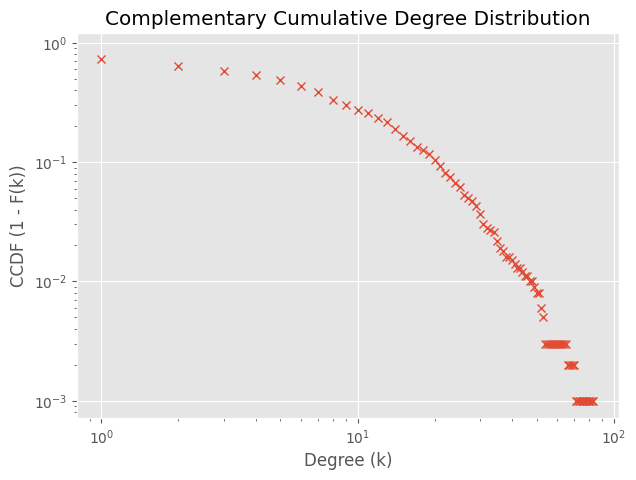

In [73]:
plot_ccdf_of_graph(G)
    

In [87]:
from collections import Counter

# Split the comma-separated strings and flatten the list
competitors_list = result_df['Competitors'].str.split(', ').explode()

# Count the frequency of each competitor
competitor_frequency = Counter(competitors_list)

# Convert the Counter object to a DataFrame for better readability
competitor_frequency_df = pd.DataFrame.from_dict(competitor_frequency, orient='index', columns=['Frequency']).reset_index()
competitor_frequency_df = competitor_frequency_df.rename(columns={'index': 'Competitor'})

# sort dataframe by frequency in descending order
competitor_frequency_df = competitor_frequency_df.sort_values(by='Frequency', ascending=False)

# remove competitors that are present in company name 
competitor_frequency_df = competitor_frequency_df[~competitor_frequency_df['Competitor'].isin(result_df['Company Name'])]
print(competitor_frequency_df.head(20))

                  Competitor  Frequency
98                Salesforce        137
339                KloudFuse        101
77                  Firebase         99
371            SAS Institute         99
376          Urchin Software         92
122                      SAP         89
362           TIBCO Software         88
359                  Alteryx         72
105   Infor Global Solutions         72
99                ServiceNow         67
152             BMC Software         61
342        Qlik Technologies         61
388                   Talend         59
341                    Birst         59
273          PayPal Holdings         59
2019    CrowdStrike Holdings         56
1988                  McAfee         55
345                 Datameer         54
1575                 Zendesk         53
1992                 Exabeam         53


## Centrality Analysis

### Calculations

In [75]:
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

### Logs and Plots

In [76]:
top_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_nodes:
    # print(f"Node: {node}, Closeness Centrality: {centrality:.4f}, Ownership Status: {G.nodes[node]['Ownership Status']}, Betweenness Centrality: {betweenness_centrality[node]:.4f}")
    top_nodes_df = pd.DataFrame(top_nodes, columns=['Node', 'Betweenness'])
    top_nodes_df['Closeness'] = top_nodes_df['Node'].map(closeness_centrality)
    top_nodes_df['Ownership Status'] = top_nodes_df['Node'].map(lambda x: G.nodes[x]['Ownership Status'])
print(top_nodes_df)

               Node  Betweenness  Closeness  \
0            Stripe     0.081219   0.256544   
1  Tableau Software     0.056497   0.286250   
2           Sisense     0.053646   0.287544   
3          Signifyd     0.051427   0.271688   
4        Epic Games     0.046405   0.151559   
5                MX     0.045303   0.266107   
6    Mythical Games     0.040540   0.180215   
7          Firework     0.033122   0.214140   
8              Kony     0.027337   0.243592   
9            Cohere     0.026238   0.252835   

                         Ownership Status  
0                Privately Held (backing)  
1  Acquired/Merged (Operating Subsidiary)  
2                Privately Held (backing)  
3                Privately Held (backing)  
4                Privately Held (backing)  
5                Privately Held (backing)  
6                Privately Held (backing)  
7                Privately Held (backing)  
8                         Acquired/Merged  
9                Privately Held (backing) 

## Community Analysis

In [77]:
# calculate the modularity and communities
communities = nx.algorithms.community.greedy_modularity_communities(G)


In [94]:
# print(f"Number of communities: {len(communities)}")
# for i, community in enumerate(communities):
#     print(f"Community {i + 1}:")
#     ownership_status = [G.nodes[node]["Ownership Status"] for node in community]
#     print(pd.Series(ownership_status).value_counts(normalize=True))

# print(f"Number of communities: {len(communities)}")
# for i, community in enumerate(communities):
#     print(f"Community {i + 1}:")
#     primary_industry_code = [G.nodes[node]["Primary Industry Code"] for node in community]
#     print(pd.Series(primary_industry_code).value_counts(normalize=True))

# print(f"Number of communities: {len(communities)}")
# for i, community in enumerate(communities):
#     print(f"Community {i + 1} with size {len(community)}:")
#     keywords = [keyword for node in community for keyword in G.nodes[node]["Keywords"].split(", ")]
#     print(pd.Series(keywords).value_counts(normalize=True))

# Calculate top betweenness centrality values for each community and their normalized valuations
for i, community in enumerate(communities[:10]):
    community_subgraph = G.subgraph(community)
    community_betweenness = nx.closeness_centrality(community_subgraph)
    top_community_nodes = sorted(community_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Top betweenness centrality values for Community {i + 1}:")
    for node, centrality in top_community_nodes:
        valuation = G.nodes[node]["Last Known Valuation"]
        normalized_valuation = valuation / max(community_subgraph.nodes[node]["Last Known Valuation"] for node in community)
        print(f"Node: {node}, Betweenness Centrality: {centrality:.4f}, Normalized Valuation: {normalized_valuation:.4f}")

Top betweenness centrality values for Community 1:
Node: Stripe, Betweenness Centrality: 0.5254, Normalized Valuation: 1.0000
Node: Revolut, Betweenness Centrality: 0.4502, Normalized Valuation: 0.6560
Node: PayPal Braintree, Betweenness Centrality: 0.4420, Normalized Valuation: 0.0083
Node: Venmo, Betweenness Centrality: 0.4357, Normalized Valuation: 0.0118
Node: KOHO, Betweenness Centrality: 0.4247, Normalized Valuation: 0.0088
Top betweenness centrality values for Community 2:
Node: Tableau Software, Betweenness Centrality: 0.5530, Normalized Valuation: 0.2429
Node: SnapLogic, Betweenness Centrality: 0.5245, Normalized Valuation: 0.0181
Node: Databricks, Betweenness Centrality: 0.5188, Normalized Valuation: 1.0000
Node: Mixpanel, Betweenness Centrality: 0.5147, Normalized Valuation: 0.0154
Node: Twilio Segment, Betweenness Centrality: 0.5147, Normalized Valuation: 0.0472
Top betweenness centrality values for Community 3:
Node: Cohere, Betweenness Centrality: 0.3732, Normalized Valua

## Plot Graph

In [ ]:
node_labels = {node: node for node in G.nodes()}

# Print graph edges with shared active investors
print("Graph Edges:")
print(len(G.edges()))
for edge in G.edges(data=True):
    print(edge)

pos = nx.spring_layout(G, k=5, iterations=100)  # Layout for visualization
nx.draw(G, pos, with_labels=False, labels=node_labels, node_color="lightblue", node_size=15)
# plt.show()

## Save Graph to GEXF

In [59]:
nx.write_gexf(G, "startup_investor_data_M&A.gexf")  # Save the graph to a file